<a href="https://colab.research.google.com/github/AnnetVasileva/machineLearning/blob/main/Practical2/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
import pandas as pd
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

import tensorflow as tf
from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [150]:
# read in data
path = '/content/drive/MyDrive/ML_ECO/'
pickle_file = 'train_set.pkl'

with open(path + pickle_file, 'rb') as f:
  train_set =pickle.load(f) 

X = train_set['X']
y = train_set['y']
X.shape

(15578, 485)

In [163]:
# data processing
# maybe not needed
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)

X_train_full = scaler.transform(X)

In [148]:
 from sklearn.feature_selection import VarianceThreshold

 var_thres = VarianceThreshold


19

In [164]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split( X_train_full, y, 
                                                    test_size=0.2, 
                                                    random_state=1,
                                                    stratify = y)


In [12]:
(y_train).sum()/len(y_train)

0.04862782859894078

In [ ]:
y_vaild.sum()/len(y_vaild)

0.048459563543003854

In [113]:
#build basic model

# correct bias
total = len(y_train)
pos = y_train.sum()
neg = total - pos
initial_bias = np.log([pos/neg])
initial_bias



model = keras.models.Sequential()
model.add(keras.layers.Dense(256,input_dim=X.shape[1],  activation="relu",  kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(rate=0.8))
model.add(keras.layers.Dense(256, activation="relu",  kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=tf.keras.initializers.Constant(initial_bias)))


In [16]:
# this should make sgd to be able to varry the learning rate
# taken from keras example
first_decay_steps = 100
initial_learning_rate = 0.1
lr_decayed_fn = (
  tf.keras.experimental.CosineDecayRestarts(
      initial_learning_rate,
      first_decay_steps))
opt = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn)

In [94]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
EPOCH = 50
BATCH_SIZE = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=METRICS)

In [95]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH,
                    callbacks=[early_stopping],
                    validation_data=(X_valid, y_valid),
                    class_weight=class_weight)

Epoch 1/50
125/125 [==============================] - 3s 15ms/step - loss: 0.5551 - tp: 266.4841 - fp: 2227.9444 - tn: 3806.3571 - fn: 47.8175 - accuracy: 0.6339 - precision: 0.1067 - recall: 0.8487 - auc: 0.8543 - val_loss: 0.4130 - val_tp: 0.0000e+00 - val_fp: 15.0000 - val_tn: 2950.0000 - val_fn: 151.0000 - val_accuracy: 0.9467 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5534
Epoch 2/50
125/125 [==============================] - 1s 7ms/step - loss: 0.5215 - tp: 241.5476 - fp: 1689.7302 - tn: 4354.7698 - fn: 62.5556 - accuracy: 0.7195 - precision: 0.1244 - recall: 0.8053 - auc: 0.8376 - val_loss: 0.3999 - val_tp: 0.0000e+00 - val_fp: 4.0000 - val_tn: 2961.0000 - val_fn: 151.0000 - val_accuracy: 0.9503 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5454
Epoch 3/50
125/125 [==============================] - 1s 8ms/step - loss: 0.5062 - tp: 252.0000 - fp: 1404.3730 - tn: 4625.5476 - fn: 66.6825 - accuracy: 0.7622 - precision: 0.1475 - recall: 0.7

In [26]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

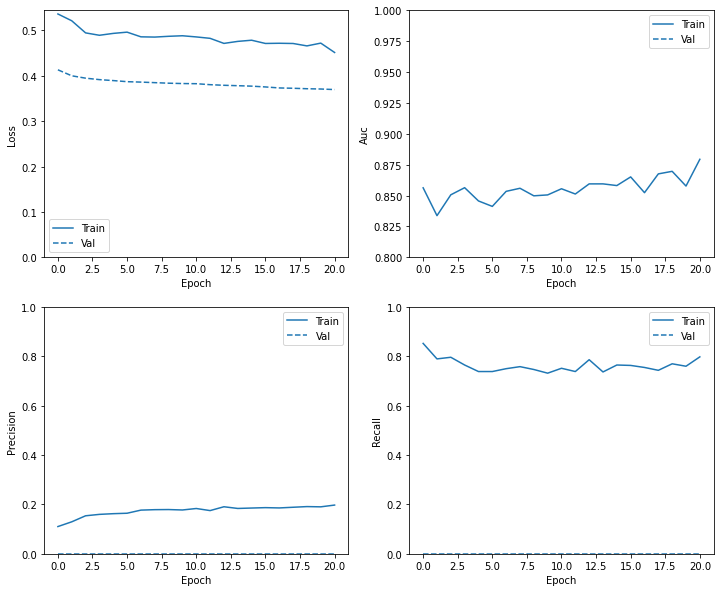

In [96]:
plot_metrics(history)

In [36]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
  auc_score = sklearn.metrics.roc_auc_score(labels, predictions)
  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

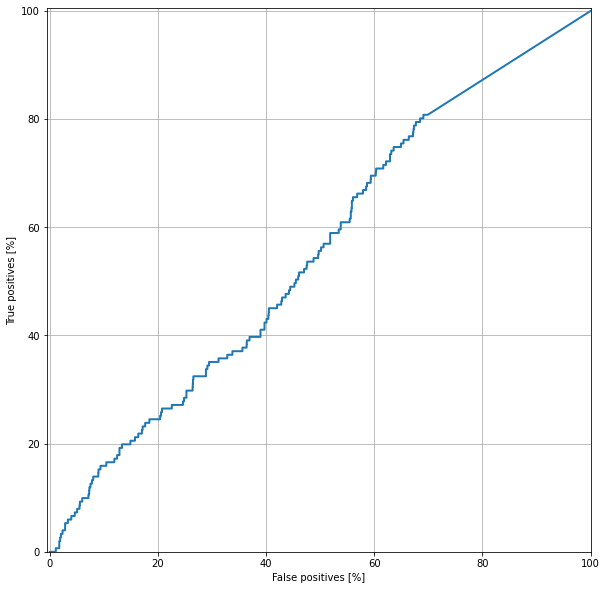

In [97]:
results = model.predict(X_valid)
plot_roc("Train Baseline", y_valid, results, color=colors[0])


In [98]:
model.evaluate(X_valid, y_valid)

98/98 [==============================] - 1s 5ms/step - loss: 0.4130 - tp: 0.0000e+00 - fp: 15.0000 - tn: 2950.0000 - fn: 151.0000 - accuracy: 0.9467 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5534


[0.41303834319114685,
 0.0,
 15.0,
 2950.0,
 151.0,
 0.9467265605926514,
 0.0,
 0.0,
 0.5533519983291626]

In [44]:
results = 1*(model.predict(X_valid)>=0.5)

In [105]:
neg_features.shape

(14821, 485)

In [166]:
#over sample data
#pos_features, pos_labels
pos_features = X_train[np.where(y_train==1)].copy()
pos_labels = y_train[np.where(y_train==1)].copy()

neg_features = X_train[np.where(y_train==0)].copy()
neg_labels = y_train[np.where(y_train==0)].copy()

BUFFER_SIZE = 10000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [167]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [154]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.45


In [155]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

238.0

In [168]:
resampled_model = keras.models.Sequential()
resampled_model.add(keras.layers.Dense(128,input_dim=X.shape[1],  activation="relu",  kernel_initializer="he_normal"))
resampled_model.add(keras.layers.Dropout(rate=0.8))
resampled_model.add(keras.layers.Dense(64, activation="relu",  kernel_initializer="he_normal"))
resampled_model.add(keras.layers.Dropout(rate=0.8))
resampled_model.add(keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=tf.keras.initializers.Constant(initial_bias)))
#resampled_model.load_weights(initial_weights)

resampled_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=METRICS)
# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

EPOCHS =25

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/25
238/238 [==============================] - 4s 10ms/step - loss: 2.5580 - tp: 4981.7490 - fp: 5039.3222 - tn: 10913.5188 - fn: 7980.9916 - accuracy: 0.5530 - precision: 0.4972 - recall: 0.3849 - auc: 0.4821 - val_loss: 0.5529 - val_tp: 31.0000 - val_fp: 680.0000 - val_tn: 2285.0000 - val_fn: 120.0000 - val_accuracy: 0.7433 - val_precision: 0.0436 - val_recall: 0.2053 - val_auc: 0.5028
Epoch 2/25
238/238 [==============================] - 2s 7ms/step - loss: 1.8958 - tp: 2633.6151 - fp: 2640.2259 - tn: 3391.8745 - fn: 3333.8661 - accuracy: 0.5010 - precision: 0.4929 - recall: 0.4361 - auc: 0.5063 - val_loss: 0.6571 - val_tp: 60.0000 - val_fp: 1134.0000 - val_tn: 1831.0000 - val_fn: 91.0000 - val_accuracy: 0.6069 - val_precision: 0.0503 - val_recall: 0.3974 - val_auc: 0.5165
Epoch 3/25
238/238 [==============================] - 2s 7ms/step - loss: 1.5872 - tp: 2905.9121 - fp: 2775.6904 - tn: 3284.2176 - fn: 3033.7615 - accuracy: 0.5150 - precision: 0.5116 - recall: 0.4874 - auc

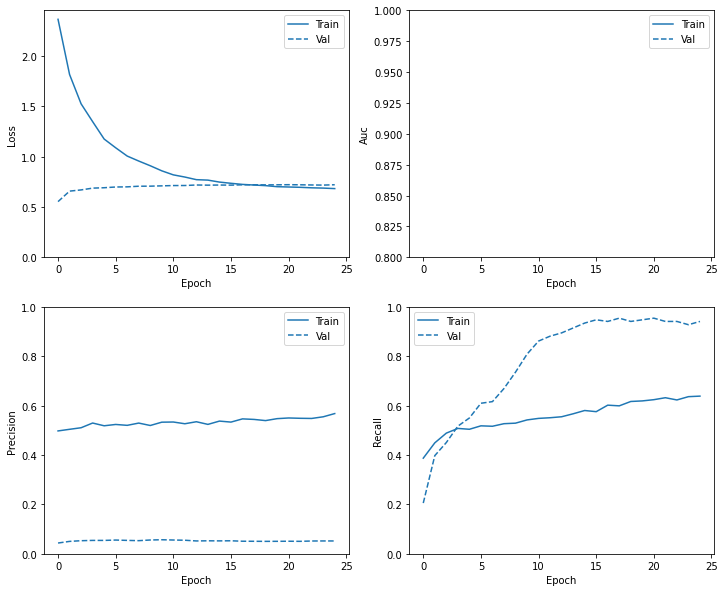

In [169]:
plot_metrics(resampled_history)

0.5878873837150866

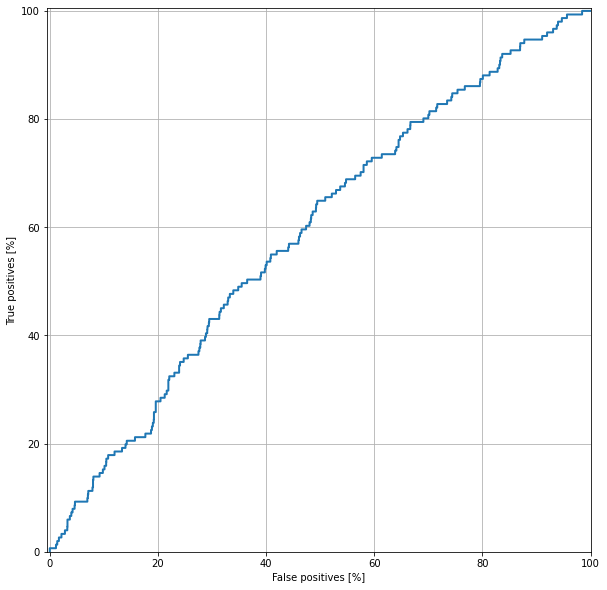

In [170]:
results_resampled = resampled_model.predict(X_valid)
plot_roc("Train Baseline", y_valid, results_resampled, color=colors[0])
sklearn.metrics.roc_auc_score(y_valid, results_resampled)